In [55]:
from IPython.display import display

In [15]:
import numpy as np

import pandas as pd

import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
framework_remapper = {
    'turing': 'Turing',
    'pymc3': 'PyMC3'
}

In [6]:
df = []
for framework in ['turing', 'pymc3']:
    
    data = pd.read_csv(f'results//tables//{framework}_results.csv')
    data['framework'] = framework_remapper[framework]
    df.append(data)

df = pd.concat(df).reset_index(drop=True)

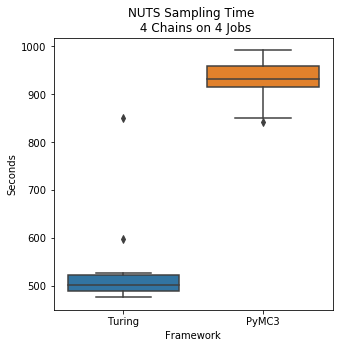

In [63]:
plt.figure(figsize=(5, 5))
sns.boxplot(
    x='framework',
    y='timing',
    data=df
)
plt.title('NUTS Sampling Time \n 4 Chains on 4 Jobs')
plt.xlabel('Framework')
plt.ylabel('Seconds')
plt.savefig('results//figures//boxplot_comp.png', dpi=400, bbox_inch='tight')
plt.show()

In [61]:
with pm.Model() as robust_comparison:
    # define data containers
    tur_timing = pm.Data(
        'turing_data',
        df[df['framework']=='Turing']['timing'].values
    )
    pym_timing = pm.Data(
        'pymc3_data',
        df[df['framework']=='PyMC3']['timing'].values
    )
    
    # define priors for the two student-t distributions parameters
    tur_mu = pm.Normal('turing_mean', mu=800, sd=100)
    pym_mu = pm.Normal('pymc3_mean', mu=800, sd=100)
    
    tur_std = pm.Exponential('turing_std', lam=1/20)
    pym_std = pm.Exponential('pymc3_std', lam=1/20)  
    
    nu = pm.Exponential('degrees_of_freedom', lam=1/20) + 1
    
    # we assume timings is coming from two student-t distributions
    # with parameters defined by the 
    tur = pm.StudentT(
        'turing_timing', 
        nu=nu, 
        mu=tur_mu, 
        lam=tur_std ** -2, 
        observed=tur_timing
    )
    pym = pm.StudentT(
        'pymc3_timing', 
        nu=nu, 
        mu=tur_mu, 
        lam=tur_std ** -2, 
        observed=tur_timing
    )
    
    # deterministally define difference of means
    diff_of_means = pm.Deterministic(
        'difference_of_means', 
        tur_mu - pym_mu
    )
    # and effect size
    effect_size = pm.Deterministic(
        'effect_size', 
        diff_of_means / np.sqrt((tur_std ** 2 + pym_std ** 2) / 2)
    )

INFO (theano.gof.compilelock): Refreshing lock C:\Users\penthotal\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_9_GenuineIntel-3.7.6-64\lock_dir\lock


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (8 chains in 1 job)
NUTS: [degrees_of_freedom, pymc3_std, turing_std, pymc3_mean, turing_mean]


Sampling 8 chains for 3_000 tune and 3_000 draw iterations (24_000 + 24_000 draws total) took 84 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
turing_mean,498.165,5.952,487.307,509.374,0.052,0.037,13178.0,13069.0,14339.0,10635.0,1.0
pymc3_mean,737.593,428.764,-66.466,1542.822,3.300,2.431,16886.0,15557.0,16858.0,15827.0,1.0
turing_std,19.185,6.469,8.518,31.032,0.059,0.044,11830.0,10782.0,13221.0,12212.0,1.0
pymc3_std,20.283,19.797,0.000,55.749,0.139,0.100,20255.0,19755.0,13845.0,8513.0,1.0
degrees_of_freedom,0.377,0.374,0.000,1.014,0.003,0.002,14192.0,14181.0,11180.0,8479.0,1.0
difference_of_means,-239.427,428.760,-1047.044,562.250,3.299,2.630,16891.0,13289.0,16856.0,15845.0,1.0
effect_size,-13.792,27.759,-69.263,37.206,0.213,0.166,17033.0,13917.0,17422.0,16430.0,1.0


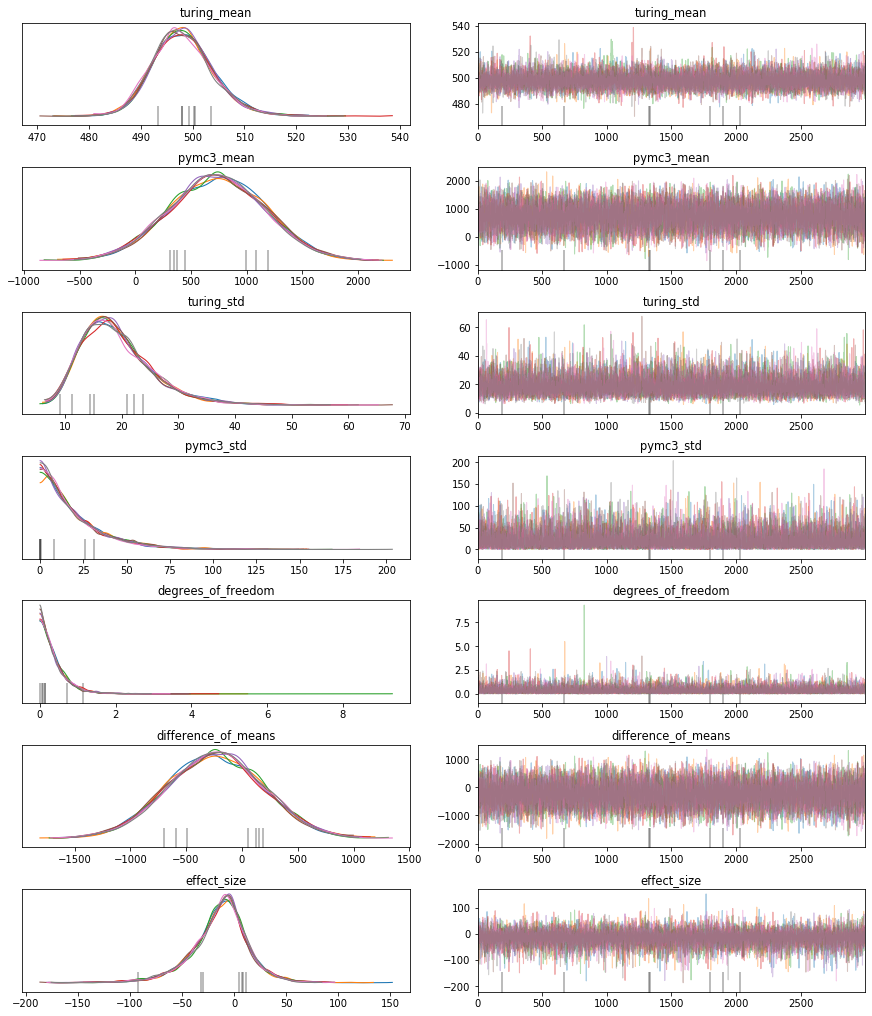

In [65]:
with t_student:
    traces = pm.sample(3000, tune=3000, cores=1, chains=8)
    
    display(pm.summary(traces))
    pm.plot_trace(traces)
    plt.savefig('results//figures//trace_plots.png', dpi=400, bbox_inch='tight')
    plt.show()

C:\Users\penthotal\miniconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


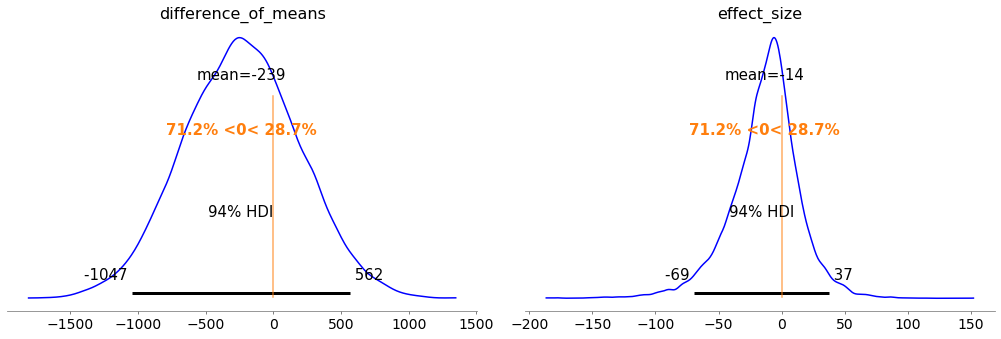

In [66]:
pm.plot_posterior(
    traces,
    var_names=['difference_of_means', 'effect_size'],
    ref_val=0,
    color='b',
)
plt.savefig('results//figures//posteriors.png', dpi=400, bbox_inch='tight')
plt.show()